# Part - II
## Clustering Techniques
* This notebook contains Agglomerative Clustering & DBSCAN.
* The connecting notebook contains KMeans Clustering.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, AveragePooling2D, UpSampling2D
from tensorflow.keras.layers import BatchNormalization
import cv2

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.metrics import pairwise_distances
import zipfile

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# https://drive.google.com/file/d/1VT-8w1rTT2GCE5IE5zFJPMzv7bqca-Ri/view?usp=sharing

with zipfile.ZipFile("/content/drive/My Drive/dataset.zip","r") as zip_ref:
  zip_ref.extractall()

In [4]:
from PIL import Image
import os
import shutil

data = []

path = 'dataset/'
for i in os.listdir(path = path):
  data.append(path + str(i))

print(len(data))

4738


In [5]:
data[:5]

['dataset/3064.jpg',
 'dataset/2195.jpg',
 'dataset/4366.jpg',
 'dataset/1748.jpg',
 'dataset/3803.jpg']

## Model Import & Feature Extraction
* The saved model is imported and loaded into the notebook model1.
* The feature at the bottom of the Encoder which is at Layer 6 from bottom of the model is considered, then flattened and then extracted as a vector.
* The vectors is very big which is 262144 dimension vector.
* Tried all kinds of architecture to reduce the dimensions to 32 filters (32, 32, 32 and 64, 64, 32 and 32, 32, 64) and 16 filters too but results were not good as the speckle from the image is removed but the image enhancement/reconstruction was worse and may be giving out bad results.

In [6]:
import tensorflow as tf
model = tf.keras.models.load_model('/content/drive/My Drive/model3.h5')

In [7]:
model1 = Sequential()
model1.add(Model(model.input, model.layers[-6].output))
model1.add(Flatten())
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 64, 64, 64)        78144     
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0         
Total params: 78,144
Trainable params: 77,760
Non-trainable params: 384
_________________________________________________________________


In [8]:
def load_images(path):
  image_list = []
  for i in path:
    img = cv2.imread(i)
    img = cv2.resize(img, (256, 256))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img/255.
    image_list.append(img)
  return image_list

## Feature Extraction
* The image features are extracted from bottom of encoder but the vector is very high dimension.
* Due to RAM constraints the data of 4000 image vectors is considered out of 4480 trained image vectors which are appx 90% of the data.
* For cross validation, 128 image vectors are considered.
* A dataframe is also shown for the reference purpose.

In [9]:

images = load_images(data[:4000])
images = np.array(images)

feats = []
for image in images:
  img = np.expand_dims(image, axis = 0)
  features = model1(img)
  features = np.reshape(features, (features.shape[1]))
  feats.append(features)


In [10]:
df = pd.DataFrame(data = np.array(feats[:10]))
df.head()

0         1         2       ...    262141    262142    262143
0 -0.625735 -0.636934 -1.076464  ... -0.761432  2.340022 -1.079394
1  0.025469 -0.636934 -0.592252  ... -0.781898  1.193589 -1.079394
2 -0.623281 -0.636934 -1.076464  ... -0.901552  0.992703 -1.079394
3 -0.512198 -0.636934 -1.076464  ... -0.906717 -0.227738 -1.079394
4 -0.649346 -0.636934 -1.076464  ... -0.887042 -0.227738 -1.037864

[5 rows x 262144 columns]

## Image Standardizing / Normalizing
* After many experiments, Normalizing the image is giving good results than standardizing of images.
* Train vectors of 4000 and CV vectors of 128 are Normalized using MinMaxScalar.
* This step is required for easy convergernce and fast running of algorithm. And most importantly due to the high contrast, the image pixels at some places are large and hence bringing all to one scale.

In [11]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

min_max_scaler = MinMaxScaler()
feats_scaled = min_max_scaler.fit_transform(feats)
feats_scaled.shape

(4000, 262144)

In [12]:
images = load_images(data[4480:4608])
images = np.array(images)

feats_cv = []
for image in images:
  img = np.expand_dims(image, axis = 0)
  features = model1(img)
  features = np.reshape(features, (features.shape[1]))
  feats_cv.append(features)


In [13]:
feats_scaled_cv = min_max_scaler.fit_transform(feats_cv)
df_cv = pd.DataFrame(feats_scaled_cv)
df_cv['images'] = data[4480:4608]
df_cv.shape

(128, 262145)

In [14]:
cols = list(df_cv.columns)
cols = [cols[-1]] + cols[:-1]
df_cv = df_cv[cols]
df_cv.head()

images         0    1  ...    262141    262142  262143
0  dataset/1635.jpg  0.118236  0.0  ...  0.059752  0.058984     0.0
1  dataset/1845.jpg  0.814395  0.0  ...  0.158415  0.446191     0.0
2  dataset/3104.jpg  0.457563  0.0  ...  0.080584  0.660613     0.0
3  dataset/2082.jpg  0.059648  0.0  ...  0.339317  0.728201     0.0
4   dataset/432.jpg  0.675940  0.0  ...  0.074334  0.723561     0.0

[5 rows x 262145 columns]

## Agglomerative Clustering

* The AgglomerativeClustering object performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together. The linkage criteria determines the metric used for the merge strategy:
  * WARD minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.
  * Maximum or COMPLETE linkage minimizes the maximum distance between observations of pairs of clusters.
  * AVERAGE linkage minimizes the average of the distances between all observations of pairs of clusters.
  * SINGLE linkage minimizes the distance between the closest observations of pairs of clusters.

* Tried various combinations of metric = 'cosine' with linkage = 'Single', 'Complete', 'Average' and metric = 'Euclidean' with the four linkages. But the Euclidean and Ward combination gave better results which are displayed below.

In [16]:
import time
start= time.time()

# The clusters choosen are based on hyperparam tuning on [5, 10, 15, 20] but 10 results in better clusters.
# Train data is fitted and cv = 'df_cv[df_cv.columns[1:]]' (as Image column is left) is used for predictions.
ac = AgglomerativeClustering(n_clusters= 10).fit(feats_scaled)
ac1 = ac.fit_predict(df_cv[df_cv.columns[1:]])

print("Time Taken is: " + str(time.time() - start))

Time Taken is: 2472.9521567821503


## Display of Clusters and their images

* The clusters 0, 1, 2, 3, 5, 9 are giving good results.
* Zero cluster is clustered with 3 Tigers only.
* One cluster is clustered with 8 Lions, 1 Wolf, 1 Fox and 1 Cheetah.
* Two cluster is clustered with 3 Tigers and 2 Cheetahs.
* Third cluster is clustered with 3 white Tigers, 1 white Lion and 2 Cheetahs.
* Fifth cluster is clustered with 3 white Tigers, 1 white Lion and 2 Wolves and 1 Cheetah.
*  Nine cluster is clustered with 5 Cheetahs, 3 Jaguars (8 lookalike), 3 Foxes and 1 Tiger.
* Rest of other clusters didnt gave good results.
* Data Imbalancing might be the cause for this behaviour

In [17]:
from collections import Counter
# Collection of clusters into a dictionary
Counter(ac1)

Counter({0: 3, 1: 15, 2: 5, 3: 31, 4: 25, 5: 7, 6: 26, 7: 1, 8: 3, 9: 12})

In [18]:
# Collection of indices and their respective images for easy display below

zero=[]
one=[]
two=[]
three=[]
four=[]
five=[]
six=[]
seven=[]
eight = []
nine=[]

# The below for loop collects the images based on clusters ad assigns them to respective clusters.
k = list(ac1)
for i in range(len(k)):
  if k[i] == 0:
    zero.append(i)
  elif k[i] == 1:
    one.append(i)
  elif k[i] == 2:
    two.append(i)
  elif k[i] == 3:
    three.append(i)
  elif k[i] == 4:
    four.append(i)
  elif k[i] == 5:
    five.append(i)
  elif k[i] == 6:
    six.append(i)
  elif k[i] == 7:
    seven.append(i)
  elif k[i] == 8:
    eight.append(i)
  elif k[i] == 9:
    nine.append(i)

### Cluster Zero

* Zero cluster is clustered with 3 Tigers only.



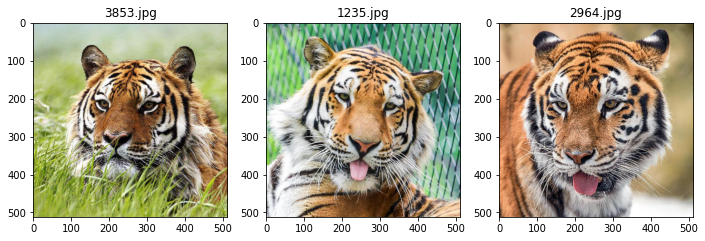

In [19]:
pics = data[4480:4608]
plt.figure(figsize= (16, 20))
for j, i in enumerate(zero):
  # nrows = 2, ncols = 3, index = i + 1
  plt.subplot(4, 4, j + 1)
  img = plt.imread(pics[i])
  plt.imshow(img)
  j = pics[i]
  plt.title(j[len(path):])

plt.show()

### Cluster One
* One cluster is clustered with 8 Lions, 1 Wolf, 1 Fox and 1 Cheetah.

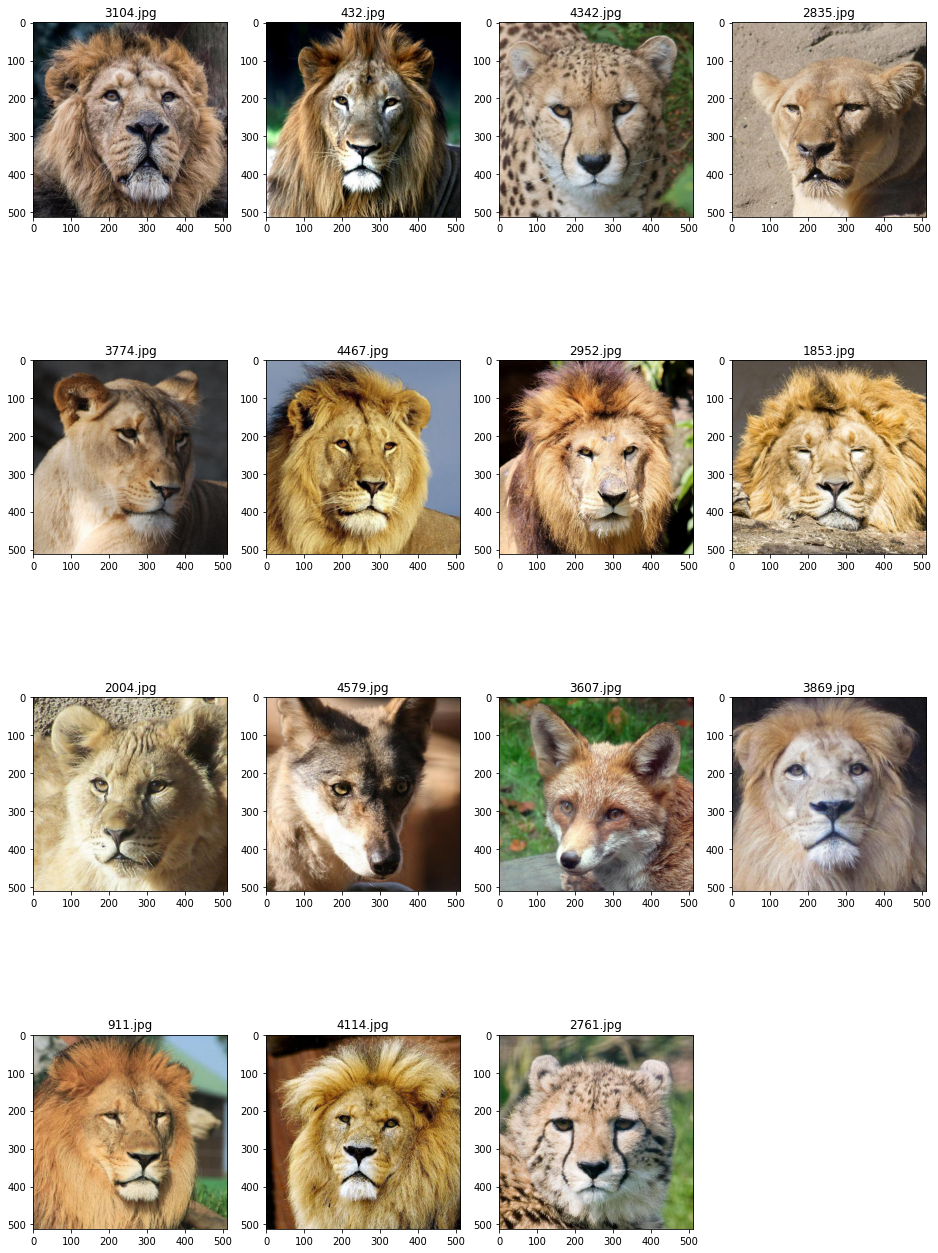

In [20]:
plt.figure(figsize= (16, 30))
for j, i in enumerate(one):
  # nrows = 2, ncols = 3, index = i + 1
  plt.subplot(5, 4, j + 1)
  img = plt.imread(pics[i])
  plt.imshow(img)
  j = pics[i]
  plt.title(j[len(path):])

plt.show()

### Cluster Two

* Two cluster is clustered with 3 Tigers and 2 Cheetahs.

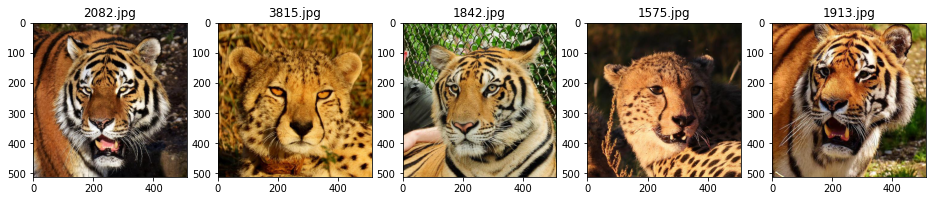

In [22]:
pics = data[4480:4608]
plt.figure(figsize= (16, 20))
for j, i in enumerate(two):
  # nrows = 2, ncols = 3, index = i + 1
  plt.subplot(1, 5, j + 1)
  img = plt.imread(pics[i])
  plt.imshow(img)
  j = pics[i]
  plt.title(j[len(path):])

plt.show()

### Cluster Five
* Fifth cluster is clustered with 3 white Tigers, 1 white Lion and 2 Wolves and 1 Cheetah.bold text

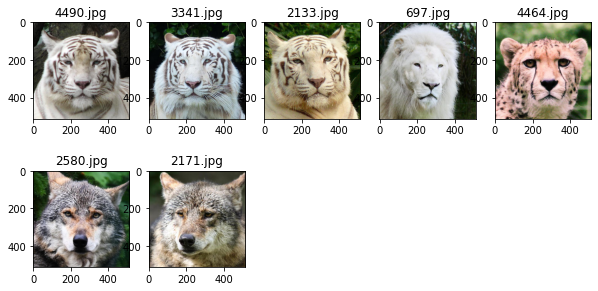

In [28]:
pics = data[4480:4608]
plt.figure(figsize= (10, 5))
for j, i in enumerate(five):
  # nrows = 2, ncols = 3, index = i + 1
  plt.subplot(2, 5, j + 1)
  img = plt.imread(pics[i])
  plt.imshow(img)
  j = pics[i]
  plt.title(j[len(path):])

plt.show()

### Cluster Nine

* Nine cluster is clustered with 5 Cheetahs, 3 Jaguars, 3 Foxes and 1 Tiger.
* The pattern of 5 Cheetahs and 3 Jaguars (8 lookalike) are almost same and hence might me classified into same cluster.

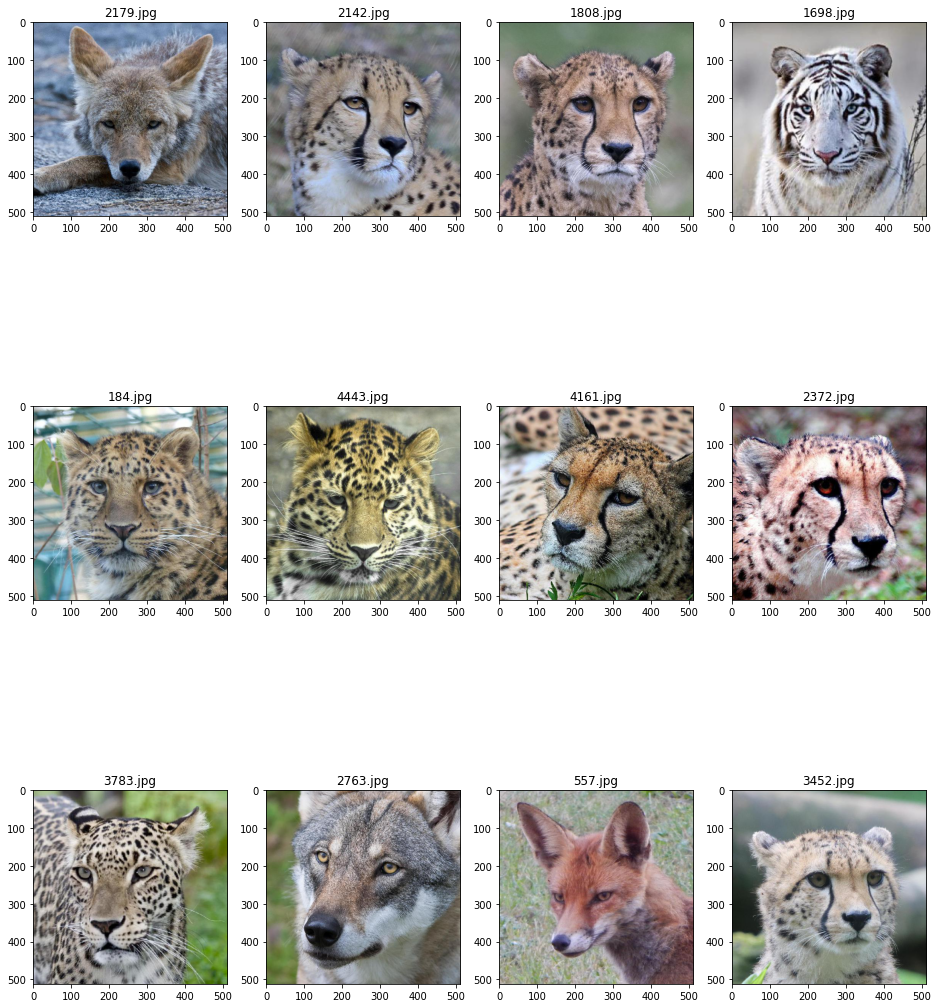

In [29]:
pics = data[4480:4608]
plt.figure(figsize= (16, 20))
for j, i in enumerate(nine):
  # nrows = 2, ncols = 3, index = i + 1
  plt.subplot(3, 4, j + 1)
  img = plt.imread(pics[i])
  plt.imshow(img)
  j = pics[i]
  plt.title(j[len(path):])

plt.show()

### Cluster Three

* Third cluster is clustered with 3 white Tigers, 1 white Lion and 2 Cheetahs.

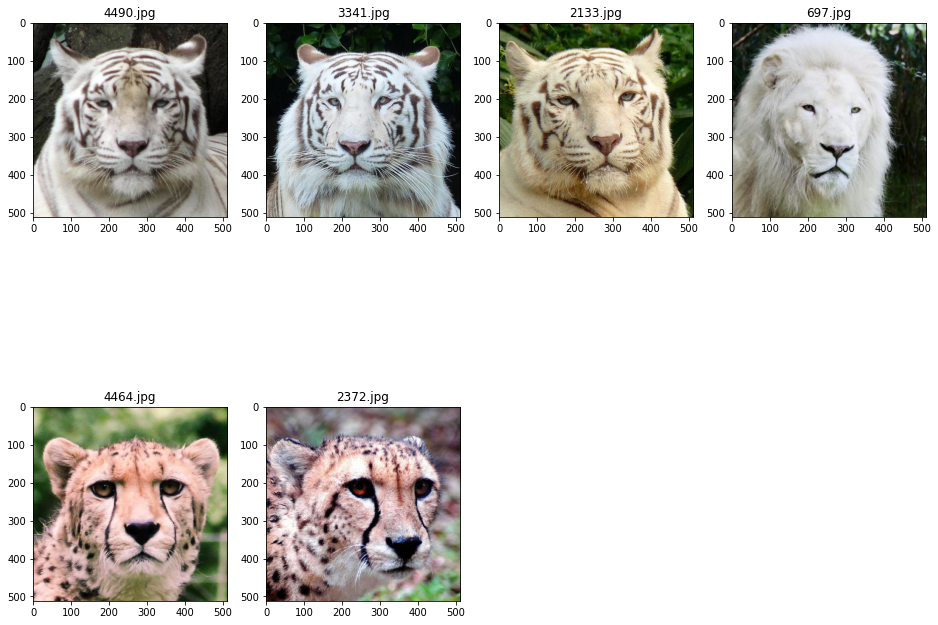

In [ ]:
pics = data[4480:4608]
plt.figure(figsize= (16, 20))
for j, i in enumerate(three):
  # nrows = 2, ncols = 3, index = i + 1
  plt.subplot(3, 4, j + 1)
  img = plt.imread(pics[i])
  plt.imshow(img)
  j = pics[i]
  plt.title(j[len(path):])

plt.show()

## DBSCAN - Density Based Spatial Clustering of Applications with Noise
* The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped.
*  There are two parameters to the algorithm, 'min_samples' and 'eps', which define formally what we mean when we say dense. Higher 'min_samples' or lower 'eps' indicate higher density necessary to form a cluster.
* The parameter 'min_samples' primarily controls how tolerant the algorithm is towards noise (on noisy and large data sets it may be desirable to increase this parameter), the parameter 'eps' is crucial to choose appropriately for the data set and distance function and usually cannot be left at the default value. It controls the local neighborhood of the points. When chosen too small, most data will not be clustered at all (and labeled as -1 for “noise”). When chosen too large, it causes close clusters to be merged into one cluster, and eventually the entire data set to be returned as a single cluster.
* The 'eps' is decided based on elbow method depicted below.
* But for min_points, i have chosen 10, 20, 25, 50, 100 but the eps remains 130.
* If min points less than 10 then eps is increasing.

In [58]:
min_points = 10
knn = NearestNeighbors(n_neighbors= min_points).fit(feats_scaled)
k_dist, index = knn.kneighbors(df_cv[df_cv.columns[1:]])

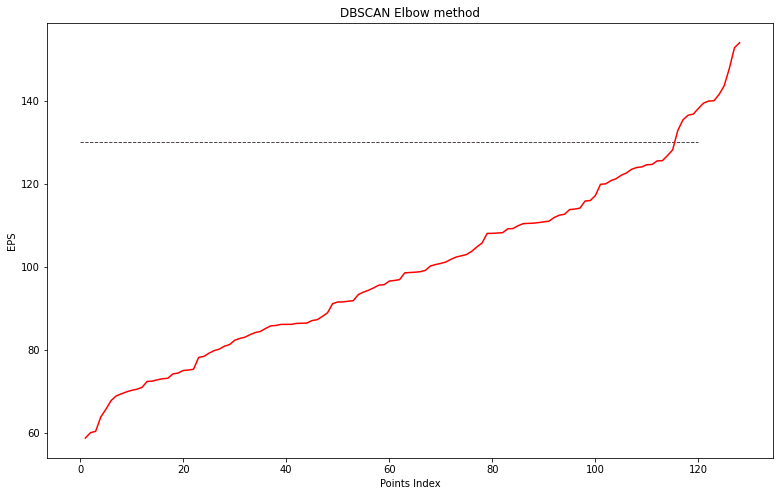

In [59]:

sort = sorted(k_dist[:,min_points-1])
plt.figure(figsize = (13, 8))
plt.plot(list(range(1,(df_cv[df_cv.columns[1:]].shape[0])+1)),sort,'r-')
# The line to indicate an Elbow formation
plt.hlines(130, 0, 120, linestyles= 'dashed', linewidth= 0.9, colors= '#3C323C')
plt.xlabel('Points Index')
plt.ylabel('EPS')
plt.title('DBSCAN Elbow method')
plt.show()

* The DBSCAN below is divided into two clusters. -1 is for noise contains 19 images. 0 is for the cluater we are looking into contains 109 images.
* As we can see this algorithm is not giving good results.

In [60]:
db = DBSCAN(eps = 130 , min_samples = min_points, ).fit_predict(df_cv[df_cv.columns[1:]])

In [61]:
Counter(db)

Counter({-1: 19, 0: 109})

### Pairwise distance Calculation

In [62]:
# A random image from 4000 images of Train data
doc_id = 100

In [70]:
# This results nearest 'num_results' images

def similar_images(num_results, doc_id):

  # distance to 'num_results' are calculated based on given image
  pairwise_dist = pairwise_distances(feats_scaled, feats_scaled[doc_id].reshape(1,-1), metric= 'cosine')
  # corresponding indices are calculated for image display purpose
  indices = np.argsort(pairwise_dist.flatten())[0:num_results]

  # Actual Image
  print('Actual Image')
  plt.imshow(plt.imread(data[doc_id]))
  plt.title(data[doc_id][len(path):])

  # Retrieved images based on Pairwise distances
  pics = data[:4000]
  plt.figure(figsize= (16, 20))
  print('Pairwise Distance calculated Images')

  for j, i in enumerate(list(indices)):
    # nrows = 2, ncols = 3, index = i + 1
    # This function can take atmost 20 images and if we want more we can change the subplots numbers here.
    plt.subplot(5, 4, j + 1)
    img = plt.imread(pics[i])
    plt.imshow(img)
    j = pics[i]
    plt.title(j[len(path):])

  plt.show()


Actual Image
Pairwise Distance calculated Images


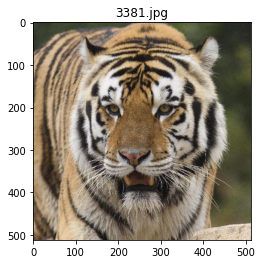

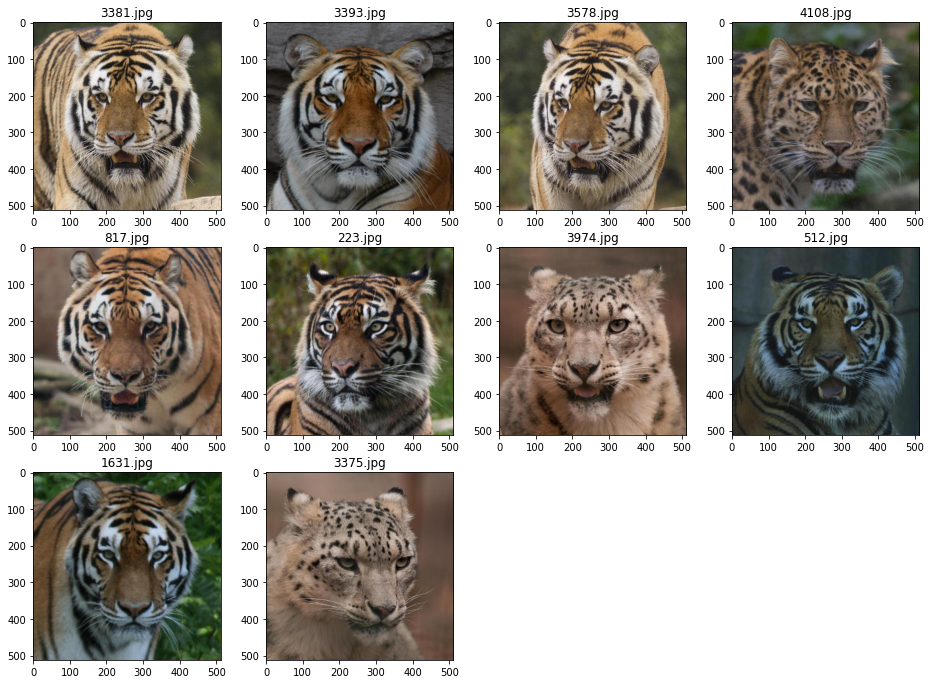

In [72]:
# given sample id out of 4000 Train images and retrival of N images and N is 10
similar_images(num_results = 10, doc_id = 102)

* As we can see above, the image is Tiger and we asked to retrieve 10 images and we got 7 images correctly out of 10. 
* simple score is 7 / 10.
* unique feature score is also 7/10 as images are Tigers and rest of images are Jaguars

Actual Image
Pairwise Distance calculated Images


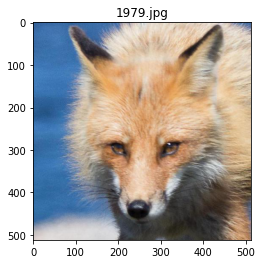

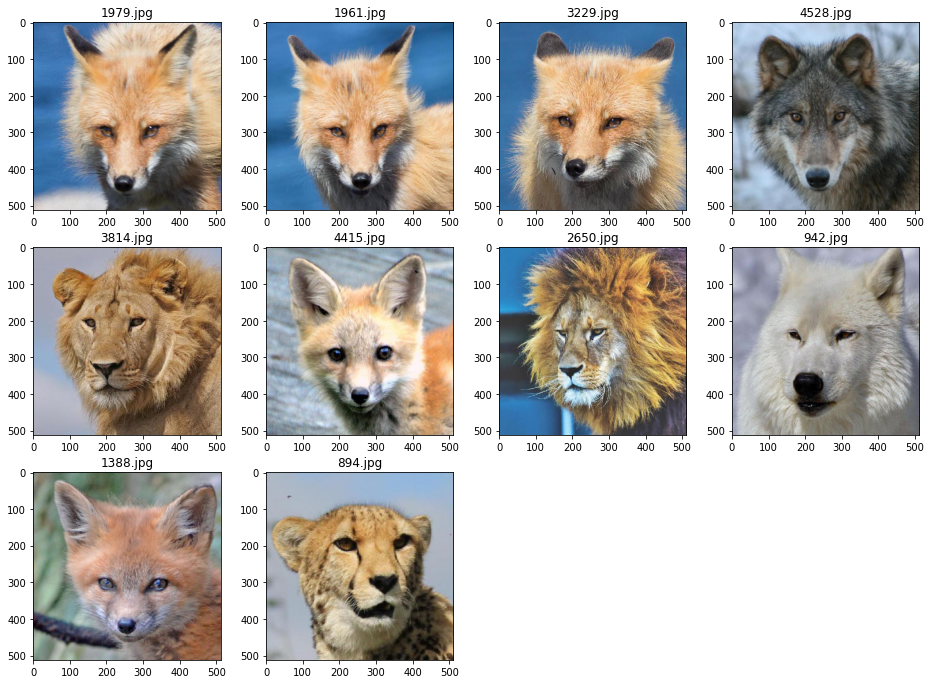

In [76]:
similar_images(num_results = 10, doc_id = 200)

* As we can see above, the image is Fox and we asked to retrieve 10 images and we got 5 images correctly out of 10. 
* simple score is 5 / 10.
* unique feature score is also 5/7 as images are 5 Foxes and 2 Wolves and rest of images are 2 Lions and 1 Cheetah.